In [472]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [473]:
df = pd.read_csv('weather-2021-preprocessed.csv')
df.head()

,Time,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Description,UV Index,Condition
0,2021-01-01 00:00:00,75,75.0,75.0,61.0,61.0,6.0,8,29.85,Low,0,Cloudy
1,2021-01-01 00:30:00,75,75.0,75.0,61.0,61.0,6.0,7,29.85,Low,0,Cloudy
2,2021-01-01 01:00:00,75,75.0,75.0,61.0,61.0,6.0,7,29.82,Low,0,Cloudy
3,2021-01-01 01:30:00,73,73.0,73.0,61.0,65.0,4.0,6,29.82,Low,0,Cloudy
4,2021-01-01 02:00:00,73,73.0,73.0,61.0,65.0,4.0,6,29.82,Low,0,Cloudy


In [474]:
df_copy = df.copy()

In [475]:
df_copy.isnull().sum()

Time                       0
Temperature                0
Heat Index                 2
Temperature Feels Like     2
Dew Point                  2
Humidity                   2
Wind Force                 0
Wind Speed                 0
Pressure                  10
UV Description             0
UV Index                   0
Condition                  0
dtype: int64

In [476]:
missing_cols = df.columns[df.isnull().any()]

In [477]:
mean = df_copy.groupby('Condition').mean()
mean

,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Index
Condition,,,,,,,,,
Cloudy,83.087897,89.488255,89.488255,74.489966,77.177116,5.554838,5.766490,29.754057,2.028936
Fair,82.007961,86.613595,86.613595,71.213411,71.656767,5.625842,6.134415,29.795993,1.859767
Fog / Haze,78.539326,80.966292,80.966292,74.528090,89.134831,1.593933,2.359551,29.813596,1.337079
Rain,80.347041,85.548193,85.548193,76.720884,89.754016,4.364343,6.597793,29.723861,1.989970
T-Storm,77.840000,80.990000,80.990000,75.980000,94.400000,2.003500,11.320000,29.731500,1.660000
Thunder,84.829268,93.493827,93.493827,75.864198,75.493827,5.304878,7.536585,29.712073,2.560976


In [478]:
for col in missing_cols:
    df_copy[col] = df_copy[col].fillna(df_copy['Condition'].map(mean[col]))

In [479]:
df_copy.isnull().sum()

Time                      0
Temperature               0
Heat Index                0
Temperature Feels Like    0
Dew Point                 0
Humidity                  0
Wind Force                0
Wind Speed                0
Pressure                  0
UV Description            0
UV Index                  0
Condition                 0
dtype: int64

# PHẦN 2: MÔ HÌNH HÓA DỮ LIỆU

## A. Mô hình hóa dữ liệu

### Giới thiệu bài toán
Dựa trên việc tìm hiểu về bộ dữ liệu thông qua các quá trình Khám phá dữ liệu và Đặt các câu hỏi có ý nghĩa cần trả lời, bài toán thích hợp cho bộ dữ liệu này là 'Dự đoán điều kiện thời tiết là nhiều mây hay không?'.

Bài toán được chọn do bộ dữ liệu có các thuộc tính biểu thị chỉ số khí hậu (numerical columns) tương ứng với cột điều kiện thời tiết (categorical column). Tuy nhiên, ở cột điều kiện thời tiết, giá trị `Cloudy` chiếm nhiều hơn hẳn các giá trị còn lại, nên việc bài toán dự đoán là nhiều mây (`Cloudy`) hay không (các trường hợp còn lại) sẽ phù hợp và tránh trường hợp dữ liệu bị lệch (biased) gây ảnh hưởng đến hiệu suất của mô hình.

### Lựa chọn thuật toán máy học
... Lý do lựa chọn thuật toán phân lớp (Classification Algorithm)

### Phân tích, lựa chọn những đặc trưng có mức độ liên quan cao, có tính quan trọng cho bài toán và tiền xử lý

Như đã trình bày ở Giới thiệu bài toán, ta tiến hành thay đổi tập giá trị ở cột `Condition`

In [480]:
condition = {'Cloudy':'Cloudy',
             'Fair':'Not Cloudy',
             'Rain':'Not Cloudy',
             'Fog / Haze':'Not Cloudy',
             'T-Storm':'Not Cloudy',
             'Thunder':'Not Cloudy'}

In [481]:
df_copy['Condition'] = df_copy['Condition'].map(condition)
set(df_copy['Condition'].to_list())

{'Cloudy', 'Not Cloudy'}

Từ quá trình đặt các câu hỏi có ý nghĩa cần trả lời, ta nhận thấy khác tháng trong năm có mối quan hệ nhất định với các biến thời tiết và điều kiện thời tiết, nên ở cột `Time` ta lấy tháng.

In [482]:
df_copy['Time'] = pd.to_datetime(df_copy['Time'])
df_copy['Time'] = df_copy['Time'].dt.month

Từ quá trình đặt các câu hỏi có ý nghĩa cần trả lời, ta nhận thấy `UV Description` và `UV Index` có mức độ tương quan nhất định, chỉ số UV có thể biểu thị cho mức độ UV nên việc có cột `UV Description` trong quá trình này là không cần thiết.

In [483]:
df_copy = df_copy.drop('UV Description', axis=1)

Thực hiện các tiền xử lý khác

In [484]:
# Import Label Encoder
from sklearn import preprocessing
# Tạo Label Encoder
le = preprocessing.LabelEncoder()
# Chuyển các chuỗi label thành số
df_copy['Condition'] = le.fit_transform(df_copy['Condition'])
df_copy

,Time,Temperature,Heat Index,Temperature Feels Like,Dew Point,Humidity,Wind Force,Wind Speed,Pressure,UV Index,Condition
0,1,75,75.0,75.0,61.0,61.0,6.0,8,29.85,0,0
1,1,75,75.0,75.0,61.0,61.0,6.0,7,29.85,0,0
2,1,75,75.0,75.0,61.0,61.0,6.0,7,29.82,0,0
3,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,0,0
4,1,73,73.0,73.0,61.0,65.0,4.0,6,29.82,0,0
...,...,...,...,...,...,...,...,...,...,...,...
17385,12,81,82.0,82.0,64.0,58.0,6.0,8,29.94,0,0
17386,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,0,0
17387,12,79,81.0,81.0,64.0,61.0,6.0,6,29.94,0,0
17388,12,79,81.0,81.0,64.0,61.0,6.0,8,29.94,0,0


## B. Huấn luyện và đánh giá mô hình

Tách tập dữ liệu thành feature và label.

In [485]:
X = df_copy[['Time', 'Temperature', 'Heat Index', 'Temperature Feels Like', 'Dew Point', 'Humidity', 'Wind Force', 'Wind Speed', 'Pressure', 'UV Index']]
y = df_copy['Condition']

Tách tập dữ liệu thành tập huấn luyện (training set) và tập kiểm tra (test set).

In [486]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

X_train = X.iloc[:13042]
X_test = X.iloc[13042:17390]
y_train = y[:13042]
y_test = y[13042:17390]

print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (13042, 10) (13042,)
Testing set shape:  (4348, 10) (4348,)


Ta tiến hành huấn luyện và đánh giá mô hình với hai mô hình phổ biến cho các phân lớp, đó chính là KNN và Naive Bayes.

### KNN Classification
KNN (K-nearest neighbor) là một trong những thuật toán supervised-learning đơn giản nhất (mà hiệu quả trong một vài trường hợp) trong Machine Learning. Khi training, thuật toán này không học một điều gì từ dữ liệu training (đây cũng là lý do thuật toán này được xếp vào loại lazy learning), mọi tính toán được thực hiện khi nó cần dự đoán kết quả của dữ liệu mới. K-nearest neighbor có thể áp dụng được vào cả hai loại của bài toán Supervised learning là Classification và Regression. KNN còn được gọi là một thuật toán Instance-based hay Memory-based learning.

Tham khảo: https://machinelearningcoban.com/2017/01/08/knn/#k-nearest-neighbor

In [487]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Kiểm tra độ chính xác của mô hình với tập kiểm định khi huấn luyện với các giá trị khác nhau của 'k' và sau đó chọn giá trị tốt nhất từ chúng.

In [488]:
# Tính độ chính xác của mô hình với các giá trị 'k' khác nhau
acc = np.zeros(20)
for i in range(1, 21):
    # Huấn luyện mô hình và dự đoán
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc[i-1] = metrics.accuracy_score(y_test, y_pred)

acc

array([0.66306348, 0.72838086, 0.68100276, 0.72447102, 0.7026219 ,
       0.73022079, 0.71343146, 0.73183073, 0.7125115 , 0.73735051,
       0.71366145, 0.72631095, 0.71136155, 0.72631095, 0.70952162,
       0.72884085, 0.71596136, 0.73137075, 0.72033119, 0.73114075])

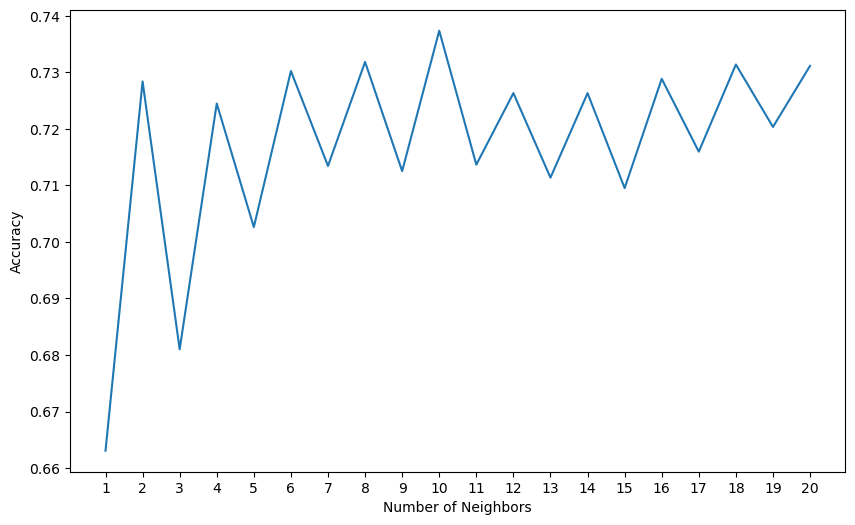

In [489]:
plt.figure(figsize = (10, 6))
plt.plot(range(1, 21), acc)
plt.xticks(np.arange(1, 21, step=1.0))
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

Độ chính xác cao nhất với giá trị của 'k' là 10

#### Xác thực siêu tham số của mô hình và báo cáo quá trình tinh chỉnh.
Để tiến hành xác thực kỹ lưỡng các siêu tham số của mô hình, nhóm đã sử dụng kỹ thuật cross-validation

In [490]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}

In [491]:
knn_cv= GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
knn_cv.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [492]:
knn_cv.best_score_

0.6270845313398505

In [493]:
knn_cv.best_params_

{'n_neighbors': 48}

In [494]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 48)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=48)

In [495]:
# Dự đoán
y_pred = knn.predict(X_test)

#### Đánh giá mô hình

Confusion Matrix

In [496]:
# Import confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[3109,  406],
       [ 742,   91]], dtype=int64)

Từ Confusion Matrix ở trên, ta có:
- TP = 3503
- FP = 12
- TN = 73
- FN = 760

Classification Report

In [497]:
# Import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3515
           1       0.18      0.11      0.14       833

    accuracy                           0.74      4348
   macro avg       0.50      0.50      0.49      4348
weighted avg       0.69      0.74      0.71      4348



In [498]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn_cv, X, y, cv=5)

In [499]:
print('Độ chính xác của mô hình: ', np.mean(scores))

Độ chính xác của mô hình:  0.6221391604370328


### Naive Bayes Classification
- Naïve Bayes là một thuật toán học có giám sát, dựa trên định lý Bayes và được sử dụng để giải các bài toán phân loại.
- Nó chủ yếu được sử dụng trong phân loại văn bản bao gồm tập dữ liệu huấn luyện chiều cao.
- Naïve Bayes Classifier là một trong những thuật toán phân lớp đơn giản và hiệu quả nhất giúp xây dựng các mô hình máy học nhanh có thể đưa ra dự đoán nhanh.
- Nó là một bộ phân loại xác suất, có nghĩa là nó dự đoán trên cơ sở xác suất của một đối tượng.
- Một số ví dụ phổ biến về thuật toán Naïve Bayes là lọc thư rác, phân tích tình cảm và phân loại bài viết.

Ta tiến hành gần giống các bước của KNN cho Naive Bayes